## Person Re-Identification
Dataset Used: P-DESTRE (http://p-destre.di.ubi.pt/)

Base Model: Inception V3 (https://arxiv.org/pdf/1512.00567v3.pdf)

Object Detection Base Model: FasterRCNN with Resnet50 backbone (https://arxiv.org/pdf/1506.01497.pdf; https://arxiv.org/abs/1512.03385)

In [1]:
# Import necessary library files
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
from PIL import Image
import os
import glob
import time
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras import backend as K
tf.__version__

'2.4.0-rc0'

In [2]:
# Set common params
iou_threshold = 0.5
detection_threshold = 0.2
siamese_threshold = 0.5
im_height = 2160
im_width = 3840
detection_im_height = 640
detection_im_width = 640
siamese_im_height = 200
siamese_im_width = 200
num_channels = 3

In [3]:
base_model = tf.keras.applications.InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(siamese_im_height, siamese_im_width, num_channels),
    include_top=False,
)
base_model.trainable = False

def l1_distance(inputs):
    input1, input2 = inputs
    output = K.abs(input1 - input2)
    return output

def l1_distance_output_shape(shapes):
    shape1, shape2 = shapes
    assert shape1 == shape2
    return (1,)

In [4]:
def siamese_model():
    input1 = Input(shape=(siamese_im_height, siamese_im_width, num_channels,))
    input2 = Input(shape=(siamese_im_height, siamese_im_width, num_channels,))
    processed_input1 = tf.keras.applications.inception_v3.preprocess_input(input1)
    processed_input2 = tf.keras.applications.inception_v3.preprocess_input(input2)
    feature_vec1 = base_model(processed_input1)
    feature_vec2 = base_model(processed_input2)
    pool1 = GlobalAveragePooling2D()(feature_vec1) # 6x6x2048 -> 2048
    pool2 = GlobalAveragePooling2D()(feature_vec2)
    distance = Lambda(l1_distance, output_shape=l1_distance_output_shape)([pool1, pool2])
    d1 = Dense(256)(distance)
    d2 = Dense(1)(d1)
    output = Activation('sigmoid')(d2)
    return Model(inputs=[input1, input2], outputs=output)

In [5]:
# Load the siamese model
siamese_model = siamese_model()
siamese_model.load_weights('../models/siamese.h5')
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 200, 200, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv_1 (TFOpLambda)  (None, 200, 200, 3)  0           input_3[0][0]                    
______________________________________________________________________________________________

In [7]:
# Load the Object Detection model
detection_model = tf.saved_model.load('../models/faster_rcnn_resnet50_640x640/saved_model/', tags=None, options=None)
print("Model loaded successfully")

Model loaded successfully


In [8]:
# Detect bounding boxes
def detect_person(image):
    
    def detect(img):
        # Resize image
        image = img.copy()
        image = cv2.resize(image, (detection_im_width, detection_im_height))
        image_np = np.expand_dims(image, axis=0)
        # Run object detection
        detector_output = detection_model(image_np)
        # Object detection model returns 35,000 objects for an image. We take top 200 objects
        classes = detector_output["detection_classes"][0].numpy()[:200] 
        scores = detector_output["detection_scores"][0].numpy()[:200]
        boxes = detector_output["detection_boxes"][0].numpy()[:200]
        return boxes, scores, classes, 200
    
    boxes, scores, classes, num = detect(image)
    # Out of 200 boxes, filter people, then filter 20 people per image/frame.
    # Where probability > detection_threshold and iou > iou_threshold
    # Visualization of the results of a detection.
    needed_boxes = []
    needed_scores = []
    for i in range(len(boxes)):
        # Class 1 represents human
        if classes[i] == 1 and scores[i]>detection_threshold: 
            needed_boxes.append(boxes[i])
            needed_scores.append(scores[i])
    
    selected_boxes, _, _, valid_detections = tf.image.combined_non_max_suppression(
        boxes = np.reshape(needed_boxes, (1, len(needed_boxes), 1, 4)),
        scores = np.reshape(needed_scores, (1, len(needed_scores), 1)),
        max_output_size_per_class=20,
        max_total_size=20,
        iou_threshold=iou_threshold,
        score_threshold=detection_threshold
    )
    boxes = selected_boxes[0,:int(valid_detections),:]
    return np.array(boxes)

In [9]:
def extract_images(frame, boxes):
    images = []
    for i, box in enumerate(boxes):
        # Crop image based on bounding box
        cropped_image = frame[int(box[1]*im_height):int(box[3]*im_height), int(box[0]*im_width):int(box[2]*im_width)]
#         cv2.imwrite('people/p'+str(i)+'.jpg', cropped_image)
        images.append(cropped_image)
    return images

In [2]:
def display_bbox(frame, boxes, ids):
    img = frame.copy()
    k = 0
    for box, i in zip(boxes, ids):
        if i != -1:
            cv2.rectangle(img,(int(box[1]*im_width),int(box[0]*im_height)),
                      (int(box[3]*im_width),int(box[2]*im_height)),(0,255,0),5)
            cv2.putText(img, str(i) , (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        k+=1
    plt.imshow(img)
    plt.show()

In [3]:
# Re-identify each image by looking through the stored image array
def reidentify(img_arr, dict_):
    prediction = []
    for person, image in dict_.items():
        pred = siamese_model.predict([img_arr, image])
        prediction.append(pred)
    check = np.argmax(prediction) if prediction else 0
    if prediction:
        if prediction[check] > siamese_threshold:
            return check, True
        else:
            return len(prediction), False
    else:
        return 0, False

In [13]:
# Reidentify all images in a frame
def reid_frame(images):
    global person_dict
    curr_dict = person_dict.copy()
    new_people = 0
    classifications = []
    for image in images:
        cv2.imwrite('../assets/0.jpg', image)
        im = Image.open('../assets/0.jpg')
        image = im.resize((siamese_im_height, siamese_im_width))
        img_arr = np.reshape(np.array((image)), (1, siamese_im_height, siamese_im_width, num_channels))
        pred, existing = reidentify(img_arr, person_dict)
        if not existing:
#             print("New Person: " + str(pred+new_people))
            curr_dict[pred+new_people] = img_arr
            classifications.append(pred+new_people)
            new_people+=1
        else:
#             print("Existing Person: " + str(pred))
            classifications.append(pred)
    person_dict = curr_dict
    return classifications

In [14]:
# Load the dataset video names
files = glob.glob('../data/P-DESTRE/videos/**/*.MP4', recursive=True)
VIDEO_COUNT = len(files)

### Run object detection + re-identification in live video

In [20]:
# Running on 10 frames per video at the rate of 1 frame per second
    
def run(vid, method='regular'):
    classifications = []
    # One frame per 30 frames will be evaluated
    frame_no = 30
    for i in range(10):
        cap = cv2.VideoCapture(vid)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
        ret, frame = cap.read()
        boxes = detect_person(frame)
        images = extract_images(frame, boxes)
        if method == 'regular':
            classify = reid_frame(images)
        elif method == 'recent':
            classify = reid_frame_recent(images)
        else:
            classify = reid_frame_feature_vect(images)
        display_bbox(frame, boxes, classify)
        classifications.append(classify)
        frame_no+=30

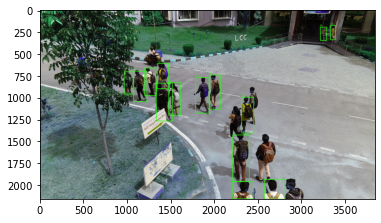

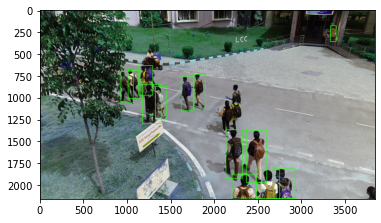

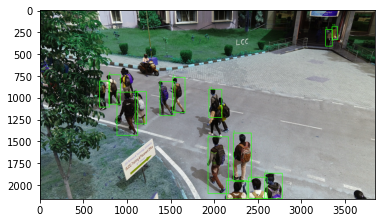

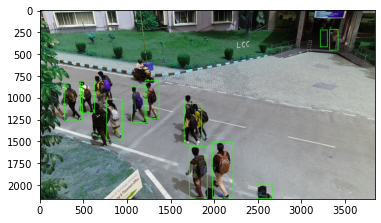

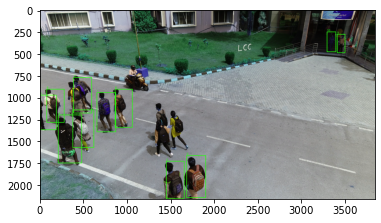

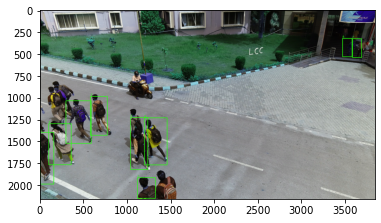

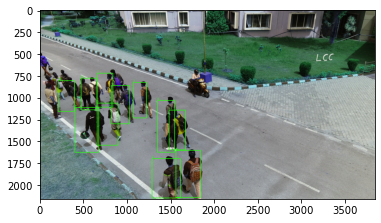

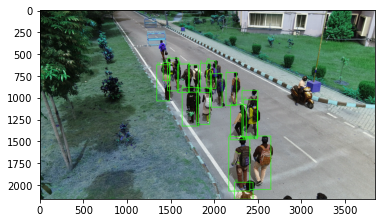

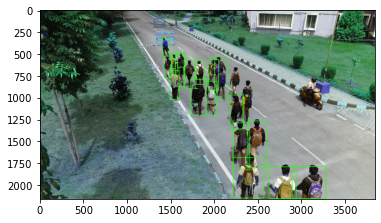

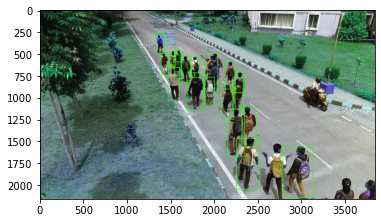

{}


In [28]:
# Running for 1 video
person_dict = {}
run(files[0], 'regular')
print(person_dict)

### Re-Identification with the most recent frame of the person

In [29]:
# Reidentify all images in a frame using the most recently identified frame
def reid_frame_recent(images):
    global person_dict_latest_img
    curr_dict = person_dict_latest_img.copy()
    new_people = 0
    classifications = []
    for image in images:
        cv2.imwrite('../assets/0.jpg', image)
        im = Image.open('../assets/0.jpg')
        image = im.resize((siamese_im_height, siamese_im_width))
        img_arr = np.reshape(np.array((image)), (1, siamese_im_height, siamese_im_width, num_channels))
        pred, existing = reidentify(img_arr, person_dict_latest_img)
        if not existing:
#             print("New Person: " + str(pred+new_people))
            curr_dict[pred+new_people] = img_arr
            classifications.append(pred+new_people)
            new_people+=1
        else:
#             print("Existing Person: " + str(pred))
            # Modifying image of existing person
            curr_dict[pred] = img_arr
            classifications.append(pred)
    person_dict_latest_img = curr_dict
    return classifications

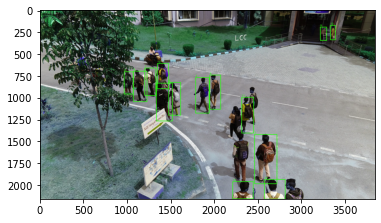

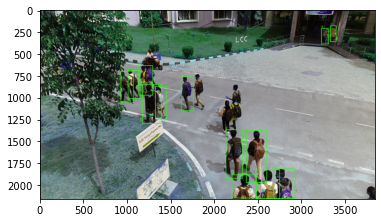

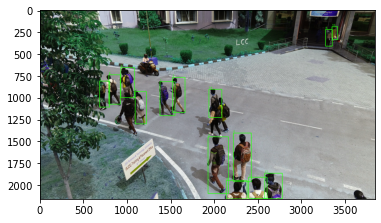

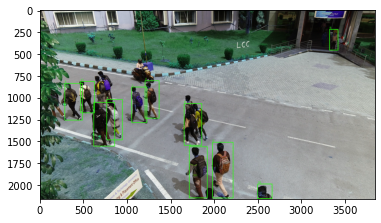

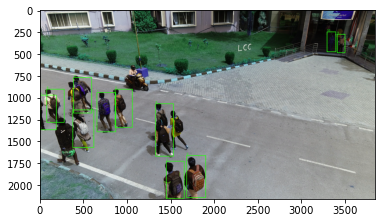

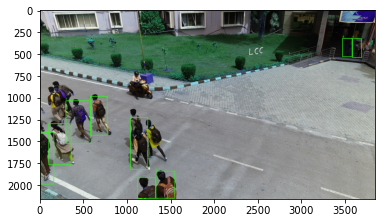

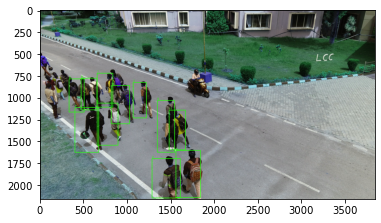

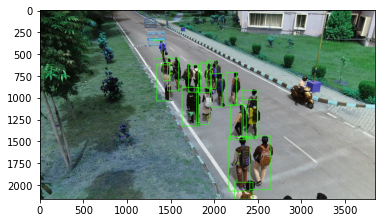

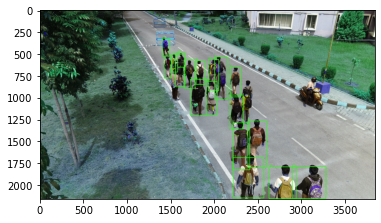

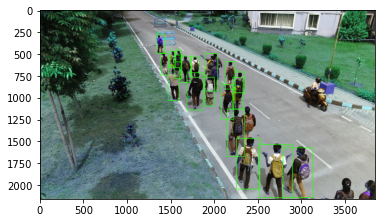

{}


In [30]:
# Running for 1 video
person_dict_latest_img = {}
run(files[0], 'recent')
print(person_dict_latest_img)

### Evaluation
### Person Re-ID evaluation
Evaluation by comparing the number of re-identified people in each frame and their corresponding ids.

In [23]:
# Reading the dataset provided annotation files
def extract_annotations(annotation):
    boxes = []
    identities = []
    temp_boxes = []
    temp_ids = []
    with open(annotation) as f:
        lines = f.readlines()
        for line in lines:
            a = line.split(',')
            if int(a[0]) % 30 == 0:
                temp = [float(x) for x in a[2:6]]
                temp_boxes.append(temp)
                temp_ids.append(int(a[1]))
            if (int(a[0])-1) % 30 == 0:
                if temp_boxes:
                    boxes.append(temp_boxes)
                    identities.append(temp_ids)
                    temp_boxes = []
                    temp_ids = []
    return boxes, identities

In [24]:
# Convert annotation IDs to standard form as those cover all 75 videos
# The annotations in the dataset are unique IDs, which are not consecutive. (234, 250,...)
# Our detection model assigns consecutive IDs starting from 0 (0, 1, 2,...)
# We need to standardize the IDs so they follow the same numbering
def standardise(identities):
    answer_classifications = []
    for i in range(len(identities)):
        temp = []
        new_dict = {}
        used_num = 0
        for val in identities[i]:
            if val not in new_dict:
                new_dict[val] = used_num
                temp.append(used_num)
                used_num+=1
            else:
                temp.append(new_dict[j])
        answer_classifications.append(temp)
    return answer_classifications


In [25]:
def extract_images_from_annotation(frame, boxes):
    images = []
    for i, box in enumerate(boxes):
        # Crop image based on bounding box
        cropped_image = frame[int(box[1]):(int(box[1])+int(box[3])), int(box[0]):(int(box[0])+int(box[2]))]
#         cv2.imwrite('people/p'+str(i)+'.jpg', cropped_image)
        images.append(cropped_image)
    return images

In [26]:
import random
def display_bbox_from_annotation(frame, boxes, ids):
    img = frame.copy()
    for box, i in zip(boxes, ids):
            continue
        if i != -1:
            cv2.rectangle(img,(int(box[0]),int(box[1])),(int(box[0]+box[2]),int(box[1]+box[3])),(36,255,12),5)
            cv2.putText(img, str(i) , (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        k+=1
    plt.imshow(img)
    plt.show()

In [27]:
def evaluate_model(ground_truth, predictions):
    correct = 0
    wrong = 0
    for gt, pred in zip(ground_truth, predictions):
        for g, p in zip(gt,pred):
            if g == p:
                correct+=1
            else:
                wrong+=1
    return correct/(correct+wrong)

In [31]:
def reid_video(vid, boxes, method='regular'):
    classifications = []
    frame_no = 30
    for i in range(5):
        print("At frame", i+1)
        cap = cv2.VideoCapture(vid)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
        ret, frame = cap.read()
        images = extract_images_from_annotation(frame, boxes[i])
        if method=='regular':
            classify = reid_frame(images)
        elif method=='recent':
            classify = reid_frame_recent(images)
        else:
            classify = reid_frame_feature_vect(images)
        classifications.append(classify)
        frame_no+=30
    return classifications

In [33]:
def run_evaluation(vid):
    global person_dict
    person_dict = {}
    # One frame per 30 frames will be evaluated
    a = '../dataset/P-DESTRE/annotation/'+files[0].split('/')[-1].split('.')[0]+'.txt'
    boxes, identities = extract_annotations(a)
    identities = standardise(identities)
    classifications = reid_video(vid, boxes, 'regular')
    accuracy = evaluate_model(identities, classifications)
    return accuracy

In [1]:

accuracies = []
person_dict = {}
for vid in files:
    accuracy = run_evaluation(vid)
    accuracies.append(accuracy)
print("Average accuracy of the model in live video is: {:.3f} %".format((sum(accuracies)*100)/VIDEO_COUNT))

Average accuracy of the model in live video is: 69.233 %


In [35]:
def run_evaluation_recent(vid):
    global person_dict_latest_img
    person_dict_latest_img = {}
    # One frame per 30 frames will be evaluated
    a = '../data/P-DESTRE/annotation/'+files[0].split('/')[-1].split('.')[0]+'.txt'
    boxes, identities = extract_annotations(a)
    identities = standardise(identities)
    classifications = reid_video(vid, boxes, 'recent')
    accuracy = evaluate_model(identities, classifications)
    return accuracy

In [47]:
accuracies = []
person_dict_latest_img = {}
for vid in files:
    accuracy = run_evaluation_recent(vid)
    accuracies.append(accuracy)
print("Average accuracy of the model using most recent image is: {:.3f} %".format((sum(accuracies)*100)/VIDEO_COUNT))

Average accuracy of the model using most recent image is: 58.731 %


### Using feature vector instead of image array
#### Performance evaluation

In [37]:
# Splitting the siamese model into three parts so the stored feature vectors can be passed to the distance function
pred_model = tf.keras.Model(siamese_model.input[1], siamese_model.get_layer('global_average_pooling2d_1').output)
pred_model.load_weights('../models/siamese.h5', by_name=True)
pred_model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 200, 200, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 200, 200, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [38]:
def second_part():
    pool1 = Input(shape=(2048))
    pool2 = Input(shape=(2048))
    distance = Lambda(l1_distance, output_shape=l1_distance_output_shape)([pool1, pool2])
    d1 = Dense(256, name='dense')(distance)
    d2 = Dense(1, name='dense_1')(d1)
    output = Activation('sigmoid')(d2)
    return Model(inputs=[pool1, pool2], outputs=output)

In [40]:
combine_model = second_part()
combine_model.load_weights('../models/siamese.h5', by_name=True)
combine_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2048)         0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          524544      lambda_2[0][0]             

In [42]:
# Testing the split-up model architecture
im = Image.open('../assets/0.jpg')
image = im.resize((siamese_im_height, siamese_im_width))
img_arr = np.reshape(np.array((image)), (1, siamese_im_height, siamese_im_width, num_channels))

feature_vect = pred_model(img_arr)
print(feature_vect.shape)
op = combine_model([feature_vect, feature_vect])
print(op)

(1, 2048)
tf.Tensor([[0.90098256]], shape=(1, 1), dtype=float32)


In [43]:
# Re-identify each image by looking through the stored image array
def reidentify_feature_vect(img_arr, dict_):
    prediction = []
    vect = pred_model(img_arr)
    for person, feature_vect in dict_.items():
        pred = combine_model.predict([vect, feature_vect])
        prediction.append(pred)
    check = np.argmin(prediction) if prediction else 0
    if prediction:
        if prediction[check] < siamese_threshold:
            return vect, check, True
        else:
            return vect, len(prediction), False
    else:
        return vect, 0, False
# Reidentify all images in a frame
def reid_frame_feature_vect(images):
    global person_dict_feature_vect
    curr_dict = person_dict_feature_vect.copy()
    new_people = 0
    classifications = []
    for image in images:
        cv2.imwrite('../assets/0.jpg', image)
        im = Image.open('../assets/0.jpg')
        image = im.resize((siamese_im_height, siamese_im_width))
        img_arr = np.reshape(np.array((image)), (1, siamese_im_height, siamese_im_width, num_channels))
        vect, pred, existing = reidentify_feature_vect(img_arr, person_dict_feature_vect)
        if not existing:
#             print("New Person: " + str(pred+new_people))
            curr_dict[pred+new_people] = vect
            classifications.append(pred+new_people)
            new_people+=1
        else:
#             print("Existing Person: " + str(pred))
            classifications.append(pred)
    person_dict_feature_vect = curr_dict
    return classifications

In [44]:
def run_evaluation_feature_vect(vid):
    global person_dict_feature_vect
    person_dict_feature_vect = {}
    # One frame per 30 frames will be evaluated
    a = '../data/P-DESTRE/annotation/'+files[0].split('/')[-1].split('.')[0]+'.txt'
    boxes, identities = extract_annotations(a)
    identities = standardise(identities)
    classifications = reid_video(vid, boxes, 'feature_vect')
    accuracy = evaluate_model(identities, classifications)
    return accuracy

In [45]:
person_dict_feature_vect = {}
run_evaluation_feature_vect(files[0])
print(person_dict_feature_vect)

At frame 1
At frame 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
At frame 3
At frame 4
At frame 5
{0: <tf.Tensor: shape=(1, 2048), dtype=float32, numpy=
array([[0.42174482, 0.        , 0.6963788 , ..., 0.840122  , 1.9965496 ,
        2.6122162 ]], dtype=float32)>, 1: <tf.Tensor: shape=(1, 2048), dtype=float32, numpy=
array([[1.0510933 , 0.21669456, 1.7601209 , ..., 2.0169883 , 2.3483353 ,
        3.0650566 ]], dtype=float32)>, 2: <tf.Tensor: shape=(1, 2048), dtype=float32, numpy=
array([[0.24085371, 0.98814523, 0.06893333, ..., 0.5041883 , 2.6833456 ,
        3.0488224 ]], dtype=float32)>, 3: <tf.Tensor: shape=(1, 2048), dtype=float32, numpy=
array([[0.24648196, 0.16400981, 0.98574775, ..., 0.7972856 , 2.8406901 ,
        3.721496  ]], dt

In [73]:
# Testing time for 5 files
files = files[:5]

person_dict = {}
t = time.time()
for i, file in enumerate(files):
    print("At File No.", i+1)
    _ = run_evaluation(file)
print("Time taken for image-image siamese network", time.time()-t)
person_dict_feature_vect = {}
t = time.time()
for i, file in enumerate(files):
    print("At File No.", i+1)
    _ = run_evaluation_feature_vect(file)
print("Time taken for image-featurevector siamese network", time.time()-t)

At File No. 1
At frame 1
At frame 2
At frame 3
At frame 4
At frame 5
At File No. 2
At frame 1
At frame 2
At frame 3
At frame 4
At frame 5
At File No. 3
At frame 1
At frame 2
At frame 3
At frame 4
At frame 5
At File No. 4
At frame 1
At frame 2
At frame 3
At frame 4
At frame 5
At File No. 5
At frame 1
At frame 2
At frame 3
At frame 4
At frame 5
Time taken for image-image siamese network 315.0
At File No. 1
At frame 1
At frame 2
At frame 3
At frame 4
At frame 5
At File No. 2
At frame 1
At frame 2
At frame 3
At frame 4
At frame 5
At File No. 3
At frame 1
At frame 2
At frame 3
At frame 4
At frame 5
At File No. 4
At frame 1
At frame 2
At frame 3
At frame 4
At frame 5
At File No. 5
At frame 1
At frame 2
At frame 3
At frame 4
At frame 5
Time taken for image-featurevector siamese network 169.69428038597107
